In [1]:
import sys
sys.path.append('../utils')

import libraries
import utils_general
from utils_general import *

%matplotlib inline

#########

from __future__ import print_function
import argparse
import torch
import torch.nn.parallel

import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torchvision.utils as vutils
from torch.autograd import Variable

parser = argparse.ArgumentParser()
parser.add_argument('--dataset', required=True,
                    help='cifar10 | lsun | imagenet | folder | lfw ')
parser.add_argument('--dataroot', type=str, help='path to dataset')
parser.add_argument('--workers', type=int,
                    help='number of data loading workers', default=8)
parser.add_argument('--batch_size', type=int,
                    default=64, help='batch size')
parser.add_argument('--image_size', type=int, default=32,
                    help='the resolution of the input image to network')
parser.add_argument('--nz', type=int, default=100,
                    help='size of the latent z vector')
parser.add_argument('--ngf', type=int, default=64)
parser.add_argument('--ndf', type=int, default=64)
parser.add_argument('--nc', type=int)

parser.add_argument('--nepoch', type=int, default=25,
                    help='number of epochs to train for')
parser.add_argument('--lr', type=float, default=0.0002,
                    help='learning rate, default=0.0002')
parser.add_argument('--beta1', type=float, default=0.5,
                    help='beta1 for adam. default=0.5')
parser.add_argument('--cpu', action='store_true',
                    help='use CPU instead of GPU')
parser.add_argument('--ngpu', type=int, default=1,
                    help='number of GPUs to use')

parser.add_argument('--netG', default='',
                    help="path to netG config")
parser.add_argument('--netE', default='',
                    help="path to netE config")
parser.add_argument('--netG_chp', default='',
                    help="path to netG (to continue training)")
parser.add_argument('--netE_chp', default='',
                    help="path to netE (to continue training)")

parser.add_argument('--save_dir', default='.',
                    help='folder to output images and model checkpoints')
parser.add_argument('--criterion', default='param',
                    help='param|nonparam, How to estimate KL')
parser.add_argument('--KL', default='qp', help='pq|qp')
parser.add_argument('--noise', default='sphere', help='normal|sphere')
parser.add_argument('--match_z', default='cos', help='none|L1|L2|cos')
parser.add_argument('--match_x', default='L1', help='none|L1|L2|cos')

parser.add_argument('--drop_lr', default=5, type=int, help='')
parser.add_argument('--save_every', default=50, type=int, help='')

parser.add_argument('--manual_seed', type=int, default=123, help='manual seed')
parser.add_argument('--start_epoch', type=int, default=0, help='epoch number to start with')

parser.add_argument(
    '--e_updates', default="1;KL_fake:1,KL_real:1,match_z:0,match_x:0",
    help='Update plan for encoder <number of updates>;[<term:weight>]'
)

parser.add_argument(
    '--g_updates', default="2;KL_fake:1,match_z:1,match_x:0",
    help='Update plan for generator <number of updates>;[<term:weight>]'
)

# opt = parser.parse_args()

# python age.py 
# --dataset celeba 
# --dataroot <data_root> 
# --image_size 64 
# --save_dir <save_dir> 
# --lr 0.0002 
# --nz 64 
# --batch_size 64 
# --netG dcgan64px 
# --netE dcgan64px 
# --nepoch 5 
# --drop_lr 5 
# --e_updates '1;KL_fake:1,KL_real:1,match_z:0,match_x:10' 
# --g_updates '3;KL_fake:1,match_z:1000,match_x:0'

# python age.py 
# --dataset celeba 
# --dataroot <data_root> 
# --image_size 64 
# --save_dir <save_dir> 
# --start_epoch 5 
# --lr 0.0002 
# --nz 64 
# --batch_size 256 
# --netG dcgan64px 
# --netE dcgan64px 
# --nepoch 6 
# --drop_lr 5   
# --e_updates '1;KL_fake:1,KL_real:1,match_z:0,match_x:15' 
# --g_updates '3;KL_fake:1,match_z:1000,match_x:0' 
# --netE_chp  <save_dir>/netE_epoch_5.pth 
# --netG_chp <save_dir>/netG_epoch_5.pth

_StoreAction(option_strings=['--g_updates'], dest='g_updates', nargs=None, const=None, default='2;KL_fake:1,match_z:1,match_x:0', type=None, choices=None, help='Update plan for generator <number of updates>;[<term:weight>]', metavar=None)

In [2]:
# print(get_available_gpus())
print(psutil.virtual_memory())

svmem(total=64388890624, available=42122481664, percent=34.6, used=7431434240, free=38537121792, active=9671426048, inactive=15456681984, buffers=55222272, cached=18365112320, shared=14324953088)


#### Setting up the options

In [3]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.utils.data
import importlib
# from .dataset import FolderWithImages
import random
import torch.backends.cudnn as cudnn
from PIL import Image

In [4]:
# setup function @utils.py

cuda = True # not opt.cpu
torch.set_num_threads(4)
dataset = 'helen'
run = ''
save_dir = 'output/helen/'
try:
    os.makedirs(save_dir)
except OSError:
    print('Directory was not created.')

manual_seed = random.randint(1, 10000)
random.seed(manual_seed)
torch.manual_seed(manual_seed)
torch.cuda.manual_seed_all(manual_seed)

cudnn.benchmark = True

if torch.cuda.is_available() and not cuda:
    print("WARNING: You have a CUDA device,"
            "so you should probably run with --cuda")

e_updates = '1;KL_fake:1,KL_real:1,match_z:0,match_x:10' 
g_updates = '3;KL_fake:1,match_z:1000,match_x:0'
    
updates = {'e': {}, 'g': {}}
updates['e']['num_updates'] = int(e_updates.split(';')[0])
updates['e'].update({x.split(':')[0]: float(x.split(':')[1]) 
                     for x in e_updates.split(';')[1].split(',')})

updates['g']['num_updates'] = int(g_updates.split(';')[0])
updates['g'].update({x.split(':')[0]: float(x.split(':')[1]) 
                     for x in g_updates.split(';')[1].split(',')})


###################

image_size = 128 # 512
batch_size = 64 # 64
workers = 16
shuffle = True
drop_last = True
train = True

nc = 3
nz = 64 #100 #'size of the latent z vector')
ngf = 64
ndf = 64
ngpu = 0 # 'number of GPUs to use')
pin_memory = True # True | If ``True``, the data loader will copy tensors into CUDA pinned memory before returning them.

noise = 'sphere' #help='normal|sphere')

netG = 'dcgan64px' 
netE = 'dcgan64px' 

netG_chp = '' # "path to netG (to continue training)"
netE_chp = '' # "path to netE (to continue training)"

lr = 0.0002
drop_lr = 100
beta1 = 0.5 # help='beta1 for adam. default=0.5'
criterion = 'param'# help='param|nonparam, How to estimate KL'
KL ='qp' # help='pq|qp'
match_z = 'cos' # help='none|L1|L2|cos'
match_x = 'L1' # help='none|L1|L2|cos'

start_epoch = 0
nepoch = 25

save_every_e = 1
save_every_b = None
dataroot = '../data/data'

# --lr 0.0002 
# --nz 64 
# --batch_size 64 
# --netG dcgan64px 
# --netE dcgan64px 
# --nepoch 5 
# --drop_lr 5 
# --e_updates '1;KL_fake:1,KL_real:1,match_z:0,match_x:10' 
# --g_updates '3;KL_fake:1,match_z:1000,match_x:0'

Directory was not created.


In [5]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.utils.data
import importlib
import random
import os
import torch.backends.cudnn as cudnn
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

##
import torch.utils.data as data
from os import listdir
from os.path import join
from PIL import Image

def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg"])

def load_img(filepath):
#     img = cv2.imread(filepath) #, cv2.IMREAD_UNCHANGED)
    img = Image.open(filepath).convert('RGB')
    return img

class FolderWithImages(data.Dataset):
    def __init__(self, root, input_transform=None, target_transform=None):
        super(FolderWithImages, self).__init__()
        self.image_filenames = [join(root, x)
                                for x in listdir(root) if is_image_file(x.lower())]

        self.input_transform = input_transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        input = load_img(self.image_filenames[index])
        target = input.copy()
        if self.input_transform:
            input = self.input_transform(input)
        if self.target_transform:
            target = self.target_transform(target)

        return input, target

    def __len__(self):
        return len(self.image_filenames)

    
def setup_dataset(dataset, dataroot, train=True, shuffle=True, drop_last=True):
    '''
    Setups dataset.
    '''
    # Usual transform
    t = transforms.Compose([
        transforms.Scale([image_size, image_size]),
        transforms.ToTensor(),
        transforms.Normalize(
            (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    if dataset in ['imagenet', 'folder', 'lfw']:
        imdir = 'train' if train else 'val'
        dataroot = os.path.join(dataroot, imdir)

        dataset = dset.ImageFolder(root=dataroot, transform=t)
    elif dataset == 'lsun':
        dataset = dset.LSUN(db_path=dataroot,
                            classes=['bedroom_train'],
                            train=train,
                            transform=t)
    elif dataset == 'cifar10':
        dataset = dset.CIFAR10(root='data/raw/cifar10',
                               download=True,
                               train=train,
                               transform=t
                               )
    elif dataset == 'mnist':
        dataset = dset.MNIST(root='data/raw/mnist',
                             download=True,
                             train=train,
                             transform=t
                             )
    elif dataset == 'svhn':
        dataset = dset.SVHN(root='data/raw/svhn',
                            download=True,
                            train=train,
                            transform=t)
    elif dataset == 'celeba':
        imdir = 'train' if train else 'val'
        dataroot = os.path.join(dataroot, imdir)

        dataset = FolderWithImages(root=dataroot,
                                   input_transform=transforms.Compose([
                                       ALICropAndScale(),
                                       transforms.ToTensor(),
                                       transforms.Normalize(
                                           (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                   ]),
                                   target_transform=transforms.ToTensor()
                                   )
    elif dataset == 'helen':
        imdir = 'train' if train else 'val'
        dataroot = os.path.join(dataroot, imdir)

        dataset = FolderWithImages(root=dataroot,
                                   input_transform=transforms.Compose([
                                       Scale(),
                                       transforms.ToTensor(),
                                       transforms.Normalize(
                                           (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                   ]),
                                   target_transform=transforms.ToTensor()
                                   )
    else:
        assert False, 'Wrong dataset name.'

    assert len(dataset) > 0, 'No images found, check your paths.'

    # Shuffle and drop last when training
    dataloader = torch.utils.data.DataLoader(dataset,
                                             batch_size=batch_size,
                                             shuffle=shuffle,
                                             num_workers=int(workers),
                                             pin_memory=pin_memory,
                                             drop_last=drop_last)
#     print(len(dataloader))
#     for i in dataloader: print(i[0].shape, i[1].shape)
        
    return InfiniteDataLoader(dataloader)
#     return dataloader

class InfiniteDataLoader(object):
    """docstring for InfiniteDataLoader"""

    def __init__(self, dataloader):
        super(InfiniteDataLoader, self).__init__()
        self.dataloader = dataloader
        self.data_iter = None

    def next(self):
        try:
            data = self.data_iter.next()
        except Exception:
            # Reached end of the dataset
            self.data_iter = iter(self.dataloader)
            data = self.data_iter.next()

        return data

    def __len__(self):
        return len(self.dataloader)

class ALICropAndScale(object):
    def __call__(self, img):
        return img.resize((64, 78), Image.ANTIALIAS).crop((0, 7, 64, 64 + 7))
    
class Scale(object):
    def __call__(self, img):
#         img = cv2.resize(img, (64, 64), cv2.INTER_AREA)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         img = Image.fromarray(img)
        img = img.resize((image_size, image_size), Image.ANTIALIAS)
        return img 

# cv::INTER_AREA interpolation, whereas to
# .   enlarge an image, it will generally look best with cv::INTER_CUBIC (slow) or cv::INTER_LINEAR
# .   (faster but still looks OK).
    
# Setup dataset
dataloader = dict(train=setup_dataset(dataset, dataroot, train=True),
                  val=setup_dataset(dataset, dataroot, train=False))

/home/ubuntu/anaconda/envs/p3/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


In [6]:
# dl = setup_dataset(dataset, dataroot, train=True)
# # len(dataloader['val'])

# def save_image(tensor, filename, nrow=8, padding=2,
#                normalize=False, range=None, scale_each=False, pad_value=0):
#     """Save a given Tensor into an image file.
#     Args:
#         tensor (Tensor or list): Image to be saved. If given a mini-batch tensor,
#             saves the tensor as a grid of images by calling ``make_grid``.
#         **kwargs: Other arguments are documented in ``make_grid``.
#     """
#     from PIL import Image
#     grid = vutils.make_grid(tensor, nrow=nrow, padding=padding, pad_value=pad_value,
#                      normalize=normalize, range=range, scale_each=scale_each)
#     ndarr = grid.mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy() # 
# #     im = Image.fromarray(ndarr)
#     im = Image.fromarray(ndarr[:,:,::-1])    
#     im.save(filename)


# def save_images(epoch):

#     real_cpu.resize_(x.data.size()).copy_(x.data)

#     # Real samples
#     save_path = '%s/real_samples.png' % save_dir
#     save_image(real_cpu[:64] / 2 + 0.5, save_path)

#     netG.eval()
#     fake = netG(fixed_z)

#     # Fake samples
#     save_path = '%s/fake_samples_epoch_%03d.png' % (save_dir, epoch)
#     save_image(fake.data[:64] / 2 + 0.5, save_path)

#     # Save reconstructions
#     populate_x(x, dataloader['val'])
#     gex = netG(netE(x)) # here - at G entry

#     t = torch.FloatTensor(x.size(0) * 2, x.size(1),
#                           x.size(2), x.size(3))

#     t[0::2] = x.data[:]
#     t[1::2] = gex.data[:]

#     save_path = '%s/reconstructions_epoch_%03d.png' % (save_dir, epoch)
#     grid = save_image(t[:64] / 2 + 0.5, save_path)
    
#     netG.train()


In [7]:
def normalize(x, dim=0):
    '''
    Projects points to a sphere.
    '''
    return x.div(x.norm(2, dim=dim).expand_as(x))

def normalize_(x, dim=0):
    '''
    Projects points to a sphere inplace.
    '''
    x.div_(x.norm(2, dim=dim).expand_as(x))

In [8]:
def weights_init(m):
    '''
    Custom weights initialization called on netG and netE
    '''
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

class _netE_Base(nn.Module):
    def __init__(self, main):
        super(_netE_Base, self).__init__()
        self.noise = noise
        self.ngpu = ngpu
        self.main = main

    def forward(self, input):
        gpu_ids = None
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 0:
            gpu_ids = range(self.ngpu)
            output = nn.parallel.data_parallel(self.main, input, gpu_ids)
        else:
            output = self.main(input)
        output = output.view(output.size(0), -1)
        if self.noise == 'sphere':
            output = normalize(output)
        return output
    
class _netG_Base(nn.Module):
    def __init__(self, main):
        super(_netG_Base, self).__init__()
        self.ngpu = ngpu
        self.main = main

    def forward(self, input):

        # Check input is either (B,C,1,1) or (B,C)
        assert input.nelement() == input.size(0) * input.size(1), 'wtf'
        input = input.view(input.size(0), input.size(1), 1, 1)

        gpu_ids = None
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 0:
            gpu_ids = range(self.ngpu)
            return nn.parallel.data_parallel(self.main, input, gpu_ids)
        else:
            return self.main(input)



def _netE():
#     ndf = opt.ndf
#     nc = opt.nc
#     nz = opt.nz

    main = nn.Sequential(
        # input is (nc) x 128 x 128
        # state size. (ndf) x 64 x 64
        nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
        # state size. (ndf) x 32 x 32
        nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf * 2),
        nn.LeakyReLU(0.2, inplace=True),
        # state size. (ndf*2) x 16 x 16
        nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf * 4),
        nn.LeakyReLU(0.2, inplace=True),
        # state size. (ndf*4) x 8 x 8
        nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf * 8),
        nn.LeakyReLU(0.2, inplace=True),
        # state size. (ndf*4) x 4 x 4
        nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf * 16),
        nn.LeakyReLU(0.2, inplace=True),
        # state size. (ndf*8) x 1 x 1
        nn.Conv2d(ndf * 16, nz, 4, 1, 0, bias=True),
    )

    return _netE_Base(main)

# ------------------------
#         G
# ------------------------


def _netG():
#     ngf = opt.ngf
#     nc = opt.nc
#     nz = opt.nz

    main = nn.Sequential(
        # input is Z, going into a convolution
        # state size. (ngf*8) x 4 x 4
        nn.ConvTranspose2d(nz, ngf * 16, 4, 1, 0, bias=False),
        nn.BatchNorm2d(ngf * 16),
        nn.ReLU(True),
        # state size. (ngf*8) x 8 x 8
        nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf * 8),
        nn.ReLU(True),
        # state size. (ngf*8) x 16 x 16
        nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf * 4),
        nn.ReLU(True),
        # state size. (ngf*4) x 32 x 32
        nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf * 2),
        nn.ReLU(True),
        # state size. (ngf*2) x 64 x 64
        nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf),
        nn.ReLU(True),
        # state size. (ngf) x 128 x 128
        nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
        nn.Tanh()
    )

    return _netG_Base(main)

def load_G():
    '''
    Loads generator model.
    '''
    netG = _netG()
    netG.apply(weights_init)
    netG.train()
    if netG_chp != '':
        netG.load_state_dict(torch.load(netG_chp).state_dict())

    print('Generator\n', netG)
    return netG

def load_E():
    '''
    Loads encoder model.
    '''
    netE = _netE()
    netE.apply(weights_init)
    netE.train()
    if netE_chp != '':
        netE.load_state_dict(torch.load(netE_chp).state_dict())

    print('Encoder\n', netE)

    return netE

# Load generator
netG = load_G()

# Load encoder
netE = load_E()

# RuntimeError: Given transposed=1, weight[64, 512, 4, 4], so expected input[64, 256, 1, 1] to have 64 channels,
# but got 256 channels instead

Generator
 _netG_Base(
  (main): Sequential(
    (0): ConvTranspose2d (64, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d (1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d (512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d (256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d (128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (14): ReLU(inplace)
    (15): ConvTranspose2d (64, 3, ke

#### Pretraining preparation

In [9]:
def var(x, dim=0):
    '''
    Calculates variance.
    '''
    x_zero_meaned = x - x.mean(dim).expand_as(x)
    return x_zero_meaned.pow(2).mean(dim)


class KLN01Loss(torch.nn.Module):

    def __init__(self, direction, minimize):
        super(KLN01Loss, self).__init__()
        self.minimize = minimize
        assert direction in ['pq', 'qp'], 'direction?'

        self.direction = direction

    def forward(self, samples):

        assert samples.nelement() == samples.size(1) * samples.size(0), 'wtf?'

        samples = samples.view(samples.size(0), -1)

        self.samples_var = var(samples)
        self.samples_mean = samples.mean(0)

        samples_mean = self.samples_mean
        samples_var = self.samples_var

        if self.direction == 'pq':
            # mu_1 = 0; sigma_1 = 1

            t1 = (1 + samples_mean.pow(2)) / (2 * samples_var.pow(2))
            t2 = samples_var.log()

            KL = (t1 + t2 - 0.5).mean()
        else:
            # mu_2 = 0; sigma_2 = 1

            t1 = (samples_var.pow(2) + samples_mean.pow(2)) / 2
            t2 = -samples_var.log()

            KL = (t1 + t2 - 0.5).mean()

        if not self.minimize:
            KL *= -1

        return KL

# ----------------------------

def pairwise_euclidean(samples):

    B = samples.size(0)

    samples_norm = samples.mul(samples).sum(1)
    samples_norm = samples_norm.expand(B, B)

    dist_mat = samples.mm(samples.t()).mul(-2) + \
        samples_norm.add(samples_norm.t())
    return dist_mat

def sample_entropy(samples):

        # Assume B x C input

    dist_mat = pairwise_euclidean(samples)

    # Get max and add it to diag
    m = dist_mat.max().detach()
    dist_mat_d = dist_mat + \
        Variable(torch.eye(dist_mat.size(0)) * (m.data[0] + 1)).cuda()

    entropy = (dist_mat_d.min(1)[0] + 1e-4).log().sum()

    entropy *= (samples.size(1) + 0.) / samples.size(0)

    return entropy

class SampleKLN01Loss(torch.nn.Module):

    def __init__(self, direction, minimize):
        super(SampleKLN01Loss, self).__init__()
        self.minimize = minimize
        assert direction in ['pq', 'qp'], 'direction?'

        self.direction = direction

    def forward(self, samples):

        assert samples.ndimension == 2, 'wft'
        samples = samples.view(samples.size(0), -1)

        self.samples_var = var(samples)
        self.samples_mean = samples.mean(0)

        if self.direction == 'pq':
            assert False, 'not possible'
        else:
            entropy = sample_entropy(samples)

            cross_entropy = - samples.pow(2).mean() / 2.

            KL = - cross_entropy - entropy

        if not self.minimize:
            KL *= -1

        return KL

In [10]:
# x = torch.FloatTensor(batch_size, nc, image_size, image_size)
# z = torch.FloatTensor(batch_size, nz, 1, 1)
# fixed_z = torch.FloatTensor(batch_size, nz, 1, 1).normal_(0, 1)
# z = fixed_z

In [11]:
x = torch.FloatTensor(batch_size, nc, image_size, image_size)
z = torch.FloatTensor(batch_size, nz, 1, 1)
fixed_z = torch.FloatTensor(batch_size, nz, 1, 1).normal_(0, 1)

def match(x, y, dist):
    '''
    Computes distance between corresponding points in `x` and `y`
    using distance `dist`.
    '''
    if dist == 'L2':
        return (x - y).pow(2).mean()
    elif dist == 'L1':
        return (x - y).abs().mean()
    elif dist == 'cos':
        x_n = normalize(x)
        y_n = normalize(y)

        return 2 - (x_n).mul(y_n).mean()
    else:
        assert dist == 'none', 'wtf ?'

def normalize(x, dim=0):
    '''
    Projects points to a sphere.
    '''
    return x.div(x.norm(2, dim=dim).expand_as(x))

def normalize_(x, dim=0):
    '''
    Projects points to a sphere inplace.
    '''
    x.div_(x.norm(2, dim=dim).expand_as(x))

if noise == 'sphere':
    normalize_(fixed_z)

if cuda:
    netE.cuda()
    netG.cuda()
    x = x.cuda()
    z, fixed_z = z.cuda(), fixed_z.cuda()

x = Variable(x)
z = Variable(z)
fixed_z = Variable(fixed_z)

# Setup optimizers
optimizerD = optim.Adam(netE.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Setup criterions
if criterion == 'param':
    print('Using parametric criterion KL_%s' % KL)
    KL_minimizer = KLN01Loss(direction=KL, minimize=True)
    KL_maximizer = KLN01Loss(direction=KL, minimize=False)
elif criterion == 'nonparam':
    print('Using NON-parametric criterion KL_%s' % KL)
    KL_minimizer = SampleKLN01Loss(direction=KL, minimize=True)
    KL_maximizer = SampleKLN01Loss(direction=KL, minimize=False)
else:
    assert False, 'criterion?'

real_cpu = torch.FloatTensor()


def save_image(tensor, filename, nrow=8, padding=2,
               normalize=False, range=None, scale_each=False, pad_value=0):
    """Save a given Tensor into an image file.
    Args:
        tensor (Tensor or list): Image to be saved. If given a mini-batch tensor,
            saves the tensor as a grid of images by calling ``make_grid``.
        **kwargs: Other arguments are documented in ``make_grid``.
    """
    from PIL import Image
    grid = vutils.make_grid(tensor, nrow=nrow, padding=padding, pad_value=pad_value,
                     normalize=normalize, range=range, scale_each=scale_each)
    ndarr = grid.mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy() # 
    im = Image.fromarray(ndarr)
#     im = Image.fromarray(ndarr[:,:,::-1])    
    im.save(filename)


def save_images(epoch):

    real_cpu.resize_(x.data.size()).copy_(x.data)

    # Real samples
    save_path = '%s/real_samples.png' % save_dir
    save_image(real_cpu[:64] / 2 + 0.5, save_path)

    netG.eval()
    fake = netG(fixed_z)

    # Fake samples
    save_path = '%s/fake_samples_epoch_%03d.png' % (save_dir, epoch)
    save_image(fake.data[:64] / 2 + 0.5, save_path)

    # Save reconstructions
    populate_x(x, dataloader['val'])
    gex = netG(netE(x)) # here - at G entry

    t = torch.FloatTensor(x.size(0) * 2, x.size(1),
                          x.size(2), x.size(3))

    t[0::2] = x.data[:]
    t[1::2] = gex.data[:]

    save_path = '%s/reconstructions_epoch_%03d.png' % (save_dir, epoch)
    grid = save_image(t[:64] / 2 + 0.5, save_path)
    
    netG.train()

def adjust_lr(epoch, drop_coef=10):
    if epoch % drop_lr == (drop_lr - 1):
        ###
        assert optimizerD.param_groups[0]['lr'] == optimizerG.param_groups[0]['lr']
        print('Adjusting learning rate from %f to %f on E and G' % (lr, lr / drop_coef))
        optimizerD.param_groups[0]['lr'] /= drop_coef
        optimizerG.param_groups[0]['lr'] /= drop_coef
        ###
#         lr /= 2
#         for param_group in optimizerD.param_groups:
#             param_group['lr'] = lr

#         for param_group in optimizerG.param_groups:
#             param_group['lr'] = lr

Using parametric criterion KL_qp


In [12]:
def populate_x(x, dataloader):
    '''
    Fills input variable `x` with data generated with dataloader
    '''
    real_cpu, _ = dataloader.next()
    x.data.resize_(real_cpu.size()).copy_(real_cpu)

def populate_z(z):
    '''
    Fills noise variable `z` with noise U(S^M)
    '''
    z.data.resize_(batch_size, nz, 1, 1)
    z.data.normal_(0, 1)
    if noise == 'sphere':
        normalize_(z.data)

In [13]:
# print(len(dataloader['train'].next()))
# print(len(dataloader['val'].next()))
# print(dataloader['train'].next()[0].shape, dataloader['train'].next()[1].shape)
# print(dataloader['train'].next()[0].shape, dataloader['train'].next()[1].shape)

# populate_x(x, dataloader['val'])
# nepoch = 10
# lr = 0.0002

In [14]:
stats = {}
losses = {'KL_real': [],
         'Ex_e': [],
         'KL_fake': [], 
         'Ez_e': [],
         'KL_fake_g': [],
         'Ex_g: ': [],
         'Ez_g_10e3': [],
        }

for epoch in range(start_epoch, nepoch):

    # Adjust learning rate
    adjust_lr(epoch)

    for i in range(len(dataloader['train'])):

        # ---------------------------
        #        Optimize over e
        # ---------------------------
        
        # e_updates = '1; KL_fake:1, KL_real:1, match_z:0, match_x:10' 
        
        KL_real_ = []
        KL_fake_ = []
        Ex_e_ = []
        Ez_e_ = []

        for e_iter in range(updates['e']['num_updates']):
            e_losses = []
            netE.zero_grad()

            # X - e(X)
            populate_x(x, dataloader['train'])
            ex = netE(x)

            # KL_real: - \Delta( e(X) , Z ) -> max_e
            KL_real = KL_minimizer(ex)
            e_losses.append(KL_real * updates['e']['KL_real'])
            # === stats ===    
            KL_real_.append(KL_real.data[0])
            
            if updates['e']['match_x'] != 0:
                # g(e(X))
                gex = netG(ex)

                # match_x: E_x||g(e(x)) - x|| -> min_e
                err = match(gex, x, match_x)
                e_losses.append(err * 10) #updates['e']['match_x'])
                # === stats === 
                Ex_e_.append(err.data[0])

            # Save some stats
            stats['real_mean'] = KL_minimizer.samples_mean.data.mean()
            stats['real_var'] = KL_minimizer.samples_var.data.mean()
            stats['KL_real'] = KL_real.data[0]

            # ================================================

            # Z - g(Z) - e(g(Z))
            populate_z(z)
            fake = netG(z).detach()
            egz = netE(fake)

            # KL_fake: \Delta( e(g(Z)) , Z ) -> max_e
            KL_fake = KL_maximizer(egz)
            e_losses.append(KL_fake * updates['e']['KL_fake'])
            # === stats === 
            KL_fake_.append(-KL_fake.data[0])
            
            if updates['e']['match_z'] != 0:
                # match_z: E_z||e(g(z)) - z|| -> min_e
                err = match(egz, z, match_z)
                e_losses.append(err * updates['e']['match_z'])
                # === stats === 
                Ez_e_.append(err.data[0])
            
            # Update e
            sum(e_losses).backward()
            optimizerD.step()

            # === stats === 
            stats['fake_mean'] = KL_maximizer.samples_mean.data.mean()
            stats['fake_var'] = KL_maximizer.samples_var.data.mean()
            stats['KL_fake'] = -KL_fake.data[0]
            
            if KL_real_: losses['KL_real'].append(np.mean(KL_real_))
            if KL_fake_: losses['KL_fake'].append(np.mean(KL_fake_))
            if Ex_e_: losses['Ex_e'].append(np.mean(Ex_e_))
            if Ez_e_: losses['Ez_e'].append(np.mean(Ez_e_))
            
        # ---------------------------
        #        Minimize over g
        # ---------------------------
        
        # g_updates = '3; KL_fake:1, match_z:1000, match_x:0'

        KL_fake_g_ = []
        Ex_g_ = []
        Ez_g_ = []
        
        for g_iter in range(updates['g']['num_updates']):
            g_losses = []
            netG.zero_grad()

            # Z - g(Z) - e(g(Z))
            populate_z(z)
            fake = netG(z)
            egz = netE(fake)

            # KL_fake: \Delta( e(g(Z)) , Z ) -> min_g
            KL_fake_g = KL_minimizer(egz)
            g_losses.append(KL_fake_g * updates['g']['KL_fake'])
            # === stats === 
            KL_fake_g_.append(KL_fake_g.data[0])
            
            if updates['g']['match_z'] != 0:
                # match_z: E_z||e(g(z)) - z|| -> min_g
                err = match(egz, z, match_z)
                err = err * updates['g']['match_z']
                g_losses.append(err)
                # === stats === 
#                 Ez_g_.append(err.data[0])
                Ez_g_.append(err.data[0] / 1000)
                
            # ==================================

            if updates['g']['match_x'] != 0:
                # X - e(X) - g(e(X))
                populate_x(x, dataloader['train'])
                ex = netE(x)
                gex = netG(ex)

                # match_x: E_x||g(e(x)) - x|| -> min_g
                err = match(gex, x, match_x)
                err = err * updates['g']['match_x']
                g_losses.append(err)
                # === stats === 
                Ex_g_.append(err.data[0])

            # Step g
            sum(g_losses).backward()
            optimizerG.step()
        
        # === stats === 
        if KL_fake_g_: losses['KL_fake_g'].append(np.mean(KL_fake_g_))
        if Ez_g_: losses['Ez_g_10e3'].append(np.mean(Ez_g_))
        if Ex_g_: losses['Ex_g'].append(np.mean(Ex_g_))
        
        # === stdout === 
        print('[{epoch}/{nepoch}][{iter}/{niter}] '
              'KL_real/fake: {KL_real:.3f}/{KL_fake:.3f} '
              'mean_real/fake: {real_mean:.3f}/{fake_mean:.3f} '
              'var_real/fake: {real_var:.3f}/{fake_var:.3f} '
              ''.format(epoch=epoch,
                        nepoch=nepoch,
                        iter=i,
                        niter=len(dataloader['train']),
                        **stats))
        # === saving === 
        
#         if save_every_b:
#             if i % save_every_b == 0: save_images(epoch)
            
        # If an epoch takes long time, dump intermediate
        if dataset in ['lsun', 'imagenet'] and (i % 5000 == 0):
            torch.save(netG, '%s/netG_epoch_%d_it_%d.pth' %
                       (save_dir, epoch, i))
            torch.save(netE, '%s/netE_epoch_%d_it_%d.pth' %
                       (save_dir, epoch, i))
    
    if epoch % save_every_e == 0: save_images(epoch)
    # do checkpointing
    torch.save(netG, '%s/netG_epoch_%d.pth' % (save_dir, epoch))
    torch.save(netE, '%s/netE_epoch_%d.pth' % (save_dir, epoch))

[0/25][0/87] KL_real/fake: 4.129/3.979 mean_real/fake: 0.010/0.014 var_real/fake: 0.011/0.012 
[0/25][1/87] KL_real/fake: 4.770/3.817 mean_real/fake: -0.001/0.015 var_real/fake: 0.006/0.014 
[0/25][2/87] KL_real/fake: 4.195/3.861 mean_real/fake: 0.011/0.001 var_real/fake: 0.010/0.013 
[0/25][3/87] KL_real/fake: 3.957/3.934 mean_real/fake: 0.005/0.019 var_real/fake: 0.012/0.013 
[0/25][4/87] KL_real/fake: 3.809/3.967 mean_real/fake: 0.007/0.012 var_real/fake: 0.014/0.013 
[0/25][5/87] KL_real/fake: 3.762/4.145 mean_real/fake: 0.006/0.025 var_real/fake: 0.014/0.012 
[0/25][6/87] KL_real/fake: 3.730/4.143 mean_real/fake: 0.010/0.011 var_real/fake: 0.015/0.012 
[0/25][7/87] KL_real/fake: 3.744/4.319 mean_real/fake: 0.005/0.037 var_real/fake: 0.014/0.010 
[0/25][8/87] KL_real/fake: 3.771/4.415 mean_real/fake: 0.018/0.035 var_real/fake: 0.014/0.010 
[0/25][9/87] KL_real/fake: 3.777/4.564 mean_real/fake: 0.014/0.039 var_real/fake: 0.014/0.009 
[0/25][10/87] KL_real/fake: 3.752/4.676 mean_real

[0/25][86/87] KL_real/fake: 4.865/4.907 mean_real/fake: 0.039/0.040 var_real/fake: 0.007/0.007 


/home/ubuntu/anaconda/envs/p3/lib/python3.6/site-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type _netG_Base. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ubuntu/anaconda/envs/p3/lib/python3.6/site-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type _netE_Base. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


[1/25][0/87] KL_real/fake: 4.798/4.861 mean_real/fake: 0.039/0.039 var_real/fake: 0.007/0.007 
[1/25][1/87] KL_real/fake: 4.720/4.643 mean_real/fake: 0.034/0.035 var_real/fake: 0.007/0.008 
[1/25][2/87] KL_real/fake: 4.657/4.522 mean_real/fake: 0.034/0.032 var_real/fake: 0.008/0.008 
[1/25][3/87] KL_real/fake: 4.682/4.682 mean_real/fake: 0.037/0.036 var_real/fake: 0.007/0.008 
[1/25][4/87] KL_real/fake: 4.714/4.730 mean_real/fake: 0.037/0.037 var_real/fake: 0.007/0.007 
[1/25][5/87] KL_real/fake: 4.749/4.795 mean_real/fake: 0.039/0.038 var_real/fake: 0.007/0.007 
[1/25][6/87] KL_real/fake: 4.618/4.645 mean_real/fake: 0.027/0.030 var_real/fake: 0.008/0.008 
[1/25][7/87] KL_real/fake: 4.752/4.738 mean_real/fake: 0.029/0.031 var_real/fake: 0.008/0.008 
[1/25][8/87] KL_real/fake: 4.918/4.884 mean_real/fake: 0.035/0.035 var_real/fake: 0.007/0.007 
[1/25][9/87] KL_real/fake: 4.627/4.650 mean_real/fake: 0.026/0.027 var_real/fake: 0.008/0.008 
[1/25][10/87] KL_real/fake: 4.680/4.729 mean_real/

[1/25][86/87] KL_real/fake: 4.812/4.735 mean_real/fake: 0.024/0.026 var_real/fake: 0.007/0.008 
[2/25][0/87] KL_real/fake: 4.733/4.701 mean_real/fake: 0.024/0.025 var_real/fake: 0.008/0.008 
[2/25][1/87] KL_real/fake: 4.656/4.651 mean_real/fake: 0.027/0.028 var_real/fake: 0.008/0.008 
[2/25][2/87] KL_real/fake: 4.637/4.616 mean_real/fake: 0.030/0.029 var_real/fake: 0.008/0.008 
[2/25][3/87] KL_real/fake: 4.744/4.693 mean_real/fake: 0.031/0.030 var_real/fake: 0.008/0.008 
[2/25][4/87] KL_real/fake: 4.741/4.711 mean_real/fake: 0.030/0.026 var_real/fake: 0.008/0.008 
[2/25][5/87] KL_real/fake: 4.727/4.689 mean_real/fake: 0.024/0.024 var_real/fake: 0.008/0.008 
[2/25][6/87] KL_real/fake: 4.811/4.741 mean_real/fake: 0.025/0.028 var_real/fake: 0.007/0.008 
[2/25][7/87] KL_real/fake: 4.837/4.810 mean_real/fake: 0.027/0.028 var_real/fake: 0.007/0.008 
[2/25][8/87] KL_real/fake: 4.833/4.784 mean_real/fake: 0.031/0.032 var_real/fake: 0.007/0.007 
[2/25][9/87] KL_real/fake: 4.783/4.766 mean_real/

[2/25][85/87] KL_real/fake: 4.670/4.700 mean_real/fake: 0.022/0.021 var_real/fake: 0.008/0.008 
[2/25][86/87] KL_real/fake: 4.753/4.750 mean_real/fake: 0.021/0.023 var_real/fake: 0.008/0.008 
[3/25][0/87] KL_real/fake: 4.729/4.700 mean_real/fake: 0.022/0.021 var_real/fake: 0.008/0.008 
[3/25][1/87] KL_real/fake: 4.707/4.683 mean_real/fake: 0.022/0.025 var_real/fake: 0.008/0.008 
[3/25][2/87] KL_real/fake: 4.692/4.653 mean_real/fake: 0.023/0.023 var_real/fake: 0.008/0.008 
[3/25][3/87] KL_real/fake: 4.623/4.581 mean_real/fake: 0.025/0.024 var_real/fake: 0.008/0.008 
[3/25][4/87] KL_real/fake: 4.620/4.616 mean_real/fake: 0.020/0.021 var_real/fake: 0.008/0.008 
[3/25][5/87] KL_real/fake: 4.754/4.705 mean_real/fake: 0.024/0.023 var_real/fake: 0.008/0.008 
[3/25][6/87] KL_real/fake: 4.749/4.685 mean_real/fake: 0.021/0.023 var_real/fake: 0.008/0.008 
[3/25][7/87] KL_real/fake: 4.703/4.677 mean_real/fake: 0.019/0.023 var_real/fake: 0.008/0.008 
[3/25][8/87] KL_real/fake: 4.656/4.629 mean_real

[3/25][84/87] KL_real/fake: 4.532/4.476 mean_real/fake: 0.010/0.009 var_real/fake: 0.009/0.009 
[3/25][85/87] KL_real/fake: 4.510/4.416 mean_real/fake: 0.008/0.008 var_real/fake: 0.009/0.009 
[3/25][86/87] KL_real/fake: 4.470/4.421 mean_real/fake: 0.010/0.006 var_real/fake: 0.009/0.009 
[4/25][0/87] KL_real/fake: 4.473/4.406 mean_real/fake: 0.010/0.008 var_real/fake: 0.009/0.010 
[4/25][1/87] KL_real/fake: 4.467/4.421 mean_real/fake: 0.011/0.009 var_real/fake: 0.009/0.009 
[4/25][2/87] KL_real/fake: 4.481/4.433 mean_real/fake: 0.009/0.007 var_real/fake: 0.009/0.009 
[4/25][3/87] KL_real/fake: 4.476/4.448 mean_real/fake: 0.009/0.007 var_real/fake: 0.009/0.009 
[4/25][4/87] KL_real/fake: 4.535/4.467 mean_real/fake: 0.010/0.012 var_real/fake: 0.009/0.009 
[4/25][5/87] KL_real/fake: 4.524/4.467 mean_real/fake: 0.010/0.010 var_real/fake: 0.009/0.009 
[4/25][6/87] KL_real/fake: 4.513/4.466 mean_real/fake: 0.008/0.011 var_real/fake: 0.009/0.009 
[4/25][7/87] KL_real/fake: 4.506/4.452 mean_rea

[4/25][83/87] KL_real/fake: 4.400/4.351 mean_real/fake: 0.009/0.010 var_real/fake: 0.009/0.010 
[4/25][84/87] KL_real/fake: 4.375/4.332 mean_real/fake: 0.006/0.009 var_real/fake: 0.010/0.010 
[4/25][85/87] KL_real/fake: 4.361/4.306 mean_real/fake: 0.004/0.009 var_real/fake: 0.010/0.010 
[4/25][86/87] KL_real/fake: 4.359/4.332 mean_real/fake: 0.004/0.001 var_real/fake: 0.010/0.010 
[5/25][0/87] KL_real/fake: 4.338/4.306 mean_real/fake: 0.008/0.006 var_real/fake: 0.010/0.010 
[5/25][1/87] KL_real/fake: 4.321/4.291 mean_real/fake: 0.002/0.007 var_real/fake: 0.010/0.010 
[5/25][2/87] KL_real/fake: 4.313/4.300 mean_real/fake: 0.000/0.006 var_real/fake: 0.010/0.010 
[5/25][3/87] KL_real/fake: 4.315/4.305 mean_real/fake: 0.002/0.002 var_real/fake: 0.010/0.010 
[5/25][4/87] KL_real/fake: 4.339/4.305 mean_real/fake: 0.005/0.004 var_real/fake: 0.010/0.010 
[5/25][5/87] KL_real/fake: 4.331/4.301 mean_real/fake: 0.004/0.007 var_real/fake: 0.010/0.010 
[5/25][6/87] KL_real/fake: 4.354/4.298 mean_re

[5/25][82/87] KL_real/fake: 4.317/4.288 mean_real/fake: 0.005/0.007 var_real/fake: 0.010/0.010 
[5/25][83/87] KL_real/fake: 4.327/4.274 mean_real/fake: 0.009/0.005 var_real/fake: 0.010/0.010 
[5/25][84/87] KL_real/fake: 4.316/4.266 mean_real/fake: 0.007/0.003 var_real/fake: 0.010/0.010 
[5/25][85/87] KL_real/fake: 4.293/4.245 mean_real/fake: 0.005/0.005 var_real/fake: 0.010/0.010 
[5/25][86/87] KL_real/fake: 4.280/4.259 mean_real/fake: 0.005/0.001 var_real/fake: 0.010/0.010 
[6/25][0/87] KL_real/fake: 4.271/4.245 mean_real/fake: 0.004/0.003 var_real/fake: 0.010/0.010 
[6/25][1/87] KL_real/fake: 4.269/4.248 mean_real/fake: 0.002/0.001 var_real/fake: 0.010/0.010 
[6/25][2/87] KL_real/fake: 4.296/4.258 mean_real/fake: 0.002/0.001 var_real/fake: 0.010/0.010 
[6/25][3/87] KL_real/fake: 4.280/4.258 mean_real/fake: 0.002/0.005 var_real/fake: 0.010/0.010 
[6/25][4/87] KL_real/fake: 4.306/4.276 mean_real/fake: 0.000/0.005 var_real/fake: 0.010/0.010 
[6/25][5/87] KL_real/fake: 4.333/4.292 mean_r

[6/25][81/87] KL_real/fake: 4.222/4.193 mean_real/fake: 0.008/-0.000 var_real/fake: 0.010/0.010 
[6/25][82/87] KL_real/fake: 4.240/4.216 mean_real/fake: 0.009/0.009 var_real/fake: 0.010/0.010 
[6/25][83/87] KL_real/fake: 4.240/4.241 mean_real/fake: 0.007/0.007 var_real/fake: 0.010/0.010 
[6/25][84/87] KL_real/fake: 4.279/4.262 mean_real/fake: 0.006/0.003 var_real/fake: 0.010/0.010 
[6/25][85/87] KL_real/fake: 4.263/4.233 mean_real/fake: 0.003/0.007 var_real/fake: 0.010/0.010 
[6/25][86/87] KL_real/fake: 4.267/4.236 mean_real/fake: 0.006/0.009 var_real/fake: 0.010/0.010 
[7/25][0/87] KL_real/fake: 4.241/4.222 mean_real/fake: 0.009/0.008 var_real/fake: 0.010/0.010 
[7/25][1/87] KL_real/fake: 4.244/4.210 mean_real/fake: 0.003/0.003 var_real/fake: 0.010/0.010 
[7/25][2/87] KL_real/fake: 4.228/4.205 mean_real/fake: 0.002/0.002 var_real/fake: 0.010/0.010 
[7/25][3/87] KL_real/fake: 4.220/4.201 mean_real/fake: 0.002/0.004 var_real/fake: 0.010/0.010 
[7/25][4/87] KL_real/fake: 4.233/4.209 mean

[7/25][80/87] KL_real/fake: 4.122/4.098 mean_real/fake: 0.001/-0.001 var_real/fake: 0.011/0.011 
[7/25][81/87] KL_real/fake: 4.118/4.092 mean_real/fake: -0.002/0.000 var_real/fake: 0.011/0.011 
[7/25][82/87] KL_real/fake: 4.125/4.098 mean_real/fake: 0.000/0.002 var_real/fake: 0.011/0.011 
[7/25][83/87] KL_real/fake: 4.132/4.101 mean_real/fake: 0.001/0.003 var_real/fake: 0.011/0.011 
[7/25][84/87] KL_real/fake: 4.134/4.098 mean_real/fake: -0.003/0.004 var_real/fake: 0.011/0.011 
[7/25][85/87] KL_real/fake: 4.149/4.124 mean_real/fake: 0.003/0.004 var_real/fake: 0.011/0.011 
[7/25][86/87] KL_real/fake: 4.157/4.135 mean_real/fake: 0.006/-0.001 var_real/fake: 0.011/0.011 
[8/25][0/87] KL_real/fake: 4.150/4.137 mean_real/fake: 0.003/0.001 var_real/fake: 0.011/0.011 
[8/25][1/87] KL_real/fake: 4.149/4.118 mean_real/fake: 0.006/0.003 var_real/fake: 0.011/0.011 
[8/25][2/87] KL_real/fake: 4.177/4.126 mean_real/fake: -0.002/0.001 var_real/fake: 0.010/0.011 
[8/25][3/87] KL_real/fake: 4.173/4.136

[8/25][78/87] KL_real/fake: 4.089/4.067 mean_real/fake: 0.002/-0.003 var_real/fake: 0.011/0.011 
[8/25][79/87] KL_real/fake: 4.072/4.045 mean_real/fake: 0.003/-0.000 var_real/fake: 0.011/0.011 
[8/25][80/87] KL_real/fake: 4.066/4.036 mean_real/fake: -0.001/0.001 var_real/fake: 0.011/0.012 
[8/25][81/87] KL_real/fake: 4.052/4.030 mean_real/fake: -0.000/-0.000 var_real/fake: 0.011/0.012 
[8/25][82/87] KL_real/fake: 4.035/4.015 mean_real/fake: 0.002/0.003 var_real/fake: 0.011/0.012 
[8/25][83/87] KL_real/fake: 4.038/4.009 mean_real/fake: -0.003/0.001 var_real/fake: 0.012/0.012 
[8/25][84/87] KL_real/fake: 4.047/4.022 mean_real/fake: -0.003/0.000 var_real/fake: 0.011/0.012 
[8/25][85/87] KL_real/fake: 4.050/4.017 mean_real/fake: -0.005/0.005 var_real/fake: 0.011/0.012 
[8/25][86/87] KL_real/fake: 4.040/4.022 mean_real/fake: -0.003/0.005 var_real/fake: 0.011/0.012 
[9/25][0/87] KL_real/fake: 4.056/4.025 mean_real/fake: 0.003/0.004 var_real/fake: 0.011/0.012 
[9/25][1/87] KL_real/fake: 4.050

[9/25][76/87] KL_real/fake: 4.051/4.029 mean_real/fake: 0.003/0.005 var_real/fake: 0.011/0.012 
[9/25][77/87] KL_real/fake: 4.054/4.028 mean_real/fake: 0.006/0.001 var_real/fake: 0.011/0.012 
[9/25][78/87] KL_real/fake: 4.036/4.024 mean_real/fake: 0.004/-0.001 var_real/fake: 0.011/0.012 
[9/25][79/87] KL_real/fake: 4.050/4.023 mean_real/fake: 0.003/0.005 var_real/fake: 0.011/0.012 
[9/25][80/87] KL_real/fake: 4.056/4.023 mean_real/fake: 0.002/0.004 var_real/fake: 0.011/0.012 
[9/25][81/87] KL_real/fake: 4.057/4.037 mean_real/fake: -0.001/0.006 var_real/fake: 0.011/0.012 
[9/25][82/87] KL_real/fake: 4.055/4.035 mean_real/fake: -0.000/-0.000 var_real/fake: 0.011/0.012 
[9/25][83/87] KL_real/fake: 4.051/4.033 mean_real/fake: 0.003/0.000 var_real/fake: 0.011/0.012 
[9/25][84/87] KL_real/fake: 4.055/4.026 mean_real/fake: 0.005/0.007 var_real/fake: 0.011/0.012 
[9/25][85/87] KL_real/fake: 4.057/4.018 mean_real/fake: 0.007/0.006 var_real/fake: 0.011/0.012 
[9/25][86/87] KL_real/fake: 4.057/4.

[10/25][73/87] KL_real/fake: 4.018/3.982 mean_real/fake: 0.003/0.001 var_real/fake: 0.012/0.012 
[10/25][74/87] KL_real/fake: 3.993/3.979 mean_real/fake: -0.006/-0.001 var_real/fake: 0.012/0.012 
[10/25][75/87] KL_real/fake: 3.995/3.973 mean_real/fake: -0.005/-0.001 var_real/fake: 0.012/0.012 
[10/25][76/87] KL_real/fake: 3.999/3.981 mean_real/fake: -0.002/0.003 var_real/fake: 0.012/0.012 
[10/25][77/87] KL_real/fake: 4.007/3.992 mean_real/fake: -0.001/-0.001 var_real/fake: 0.012/0.012 
[10/25][78/87] KL_real/fake: 4.011/3.999 mean_real/fake: -0.002/0.003 var_real/fake: 0.012/0.012 
[10/25][79/87] KL_real/fake: 4.015/3.993 mean_real/fake: -0.002/0.002 var_real/fake: 0.012/0.012 
[10/25][80/87] KL_real/fake: 4.017/4.000 mean_real/fake: 0.001/-0.005 var_real/fake: 0.012/0.012 
[10/25][81/87] KL_real/fake: 4.013/3.998 mean_real/fake: -0.001/-0.004 var_real/fake: 0.012/0.012 
[10/25][82/87] KL_real/fake: 4.017/3.983 mean_real/fake: -0.004/-0.002 var_real/fake: 0.012/0.012 
[10/25][83/87] K

[11/25][70/87] KL_real/fake: 3.971/3.957 mean_real/fake: 0.004/-0.003 var_real/fake: 0.012/0.012 
[11/25][71/87] KL_real/fake: 3.992/3.962 mean_real/fake: 0.007/0.001 var_real/fake: 0.012/0.012 
[11/25][72/87] KL_real/fake: 3.990/3.964 mean_real/fake: 0.004/0.005 var_real/fake: 0.012/0.012 
[11/25][73/87] KL_real/fake: 3.991/3.956 mean_real/fake: 0.008/0.004 var_real/fake: 0.012/0.012 
[11/25][74/87] KL_real/fake: 3.969/3.961 mean_real/fake: 0.004/0.002 var_real/fake: 0.012/0.012 
[11/25][75/87] KL_real/fake: 3.985/3.962 mean_real/fake: 0.006/0.006 var_real/fake: 0.012/0.012 
[11/25][76/87] KL_real/fake: 3.984/3.963 mean_real/fake: 0.007/0.004 var_real/fake: 0.012/0.012 
[11/25][77/87] KL_real/fake: 3.990/3.973 mean_real/fake: 0.005/0.008 var_real/fake: 0.012/0.012 
[11/25][78/87] KL_real/fake: 3.979/3.958 mean_real/fake: 0.003/0.004 var_real/fake: 0.012/0.012 
[11/25][79/87] KL_real/fake: 3.982/3.957 mean_real/fake: -0.001/0.003 var_real/fake: 0.012/0.012 
[11/25][80/87] KL_real/fake:

[12/25][67/87] KL_real/fake: 3.937/3.921 mean_real/fake: -0.002/-0.003 var_real/fake: 0.012/0.013 
[12/25][68/87] KL_real/fake: 3.944/3.927 mean_real/fake: -0.003/0.000 var_real/fake: 0.012/0.012 
[12/25][69/87] KL_real/fake: 3.936/3.925 mean_real/fake: -0.001/-0.004 var_real/fake: 0.012/0.013 
[12/25][70/87] KL_real/fake: 3.946/3.939 mean_real/fake: -0.003/-0.011 var_real/fake: 0.012/0.012 
[12/25][71/87] KL_real/fake: 3.973/3.943 mean_real/fake: -0.006/-0.001 var_real/fake: 0.012/0.012 
[12/25][72/87] KL_real/fake: 3.961/3.933 mean_real/fake: -0.007/-0.000 var_real/fake: 0.012/0.012 
[12/25][73/87] KL_real/fake: 3.962/3.938 mean_real/fake: -0.009/-0.004 var_real/fake: 0.012/0.012 
[12/25][74/87] KL_real/fake: 3.961/3.940 mean_real/fake: -0.003/0.002 var_real/fake: 0.012/0.012 
[12/25][75/87] KL_real/fake: 3.963/3.934 mean_real/fake: -0.004/-0.005 var_real/fake: 0.012/0.012 
[12/25][76/87] KL_real/fake: 3.947/3.929 mean_real/fake: -0.005/-0.006 var_real/fake: 0.012/0.012 
[12/25][77/8

[13/25][64/87] KL_real/fake: 3.926/3.913 mean_real/fake: -0.005/-0.001 var_real/fake: 0.012/0.013 
[13/25][65/87] KL_real/fake: 3.929/3.912 mean_real/fake: -0.001/0.000 var_real/fake: 0.012/0.013 
[13/25][66/87] KL_real/fake: 3.927/3.908 mean_real/fake: -0.003/-0.001 var_real/fake: 0.012/0.013 
[13/25][67/87] KL_real/fake: 3.912/3.902 mean_real/fake: -0.001/-0.006 var_real/fake: 0.013/0.013 
[13/25][68/87] KL_real/fake: 3.905/3.896 mean_real/fake: -0.002/-0.000 var_real/fake: 0.013/0.013 
[13/25][69/87] KL_real/fake: 3.920/3.894 mean_real/fake: 0.004/-0.001 var_real/fake: 0.013/0.013 
[13/25][70/87] KL_real/fake: 3.906/3.889 mean_real/fake: -0.001/-0.004 var_real/fake: 0.013/0.013 
[13/25][71/87] KL_real/fake: 3.917/3.888 mean_real/fake: -0.002/-0.003 var_real/fake: 0.013/0.013 
[13/25][72/87] KL_real/fake: 3.905/3.889 mean_real/fake: -0.002/-0.001 var_real/fake: 0.013/0.013 
[13/25][73/87] KL_real/fake: 3.910/3.898 mean_real/fake: -0.006/0.002 var_real/fake: 0.013/0.013 
[13/25][74/87

[14/25][61/87] KL_real/fake: 3.914/3.888 mean_real/fake: 0.002/-0.002 var_real/fake: 0.013/0.013 
[14/25][62/87] KL_real/fake: 3.905/3.880 mean_real/fake: -0.001/-0.000 var_real/fake: 0.013/0.013 
[14/25][63/87] KL_real/fake: 3.899/3.886 mean_real/fake: 0.004/0.004 var_real/fake: 0.013/0.013 
[14/25][64/87] KL_real/fake: 3.898/3.885 mean_real/fake: -0.004/-0.001 var_real/fake: 0.013/0.013 
[14/25][65/87] KL_real/fake: 3.894/3.883 mean_real/fake: 0.001/0.004 var_real/fake: 0.013/0.013 
[14/25][66/87] KL_real/fake: 3.900/3.896 mean_real/fake: 0.002/-0.008 var_real/fake: 0.013/0.013 
[14/25][67/87] KL_real/fake: 3.901/3.883 mean_real/fake: -0.001/-0.003 var_real/fake: 0.013/0.013 
[14/25][68/87] KL_real/fake: 3.894/3.883 mean_real/fake: -0.001/0.002 var_real/fake: 0.013/0.013 
[14/25][69/87] KL_real/fake: 3.900/3.879 mean_real/fake: 0.002/0.001 var_real/fake: 0.013/0.013 
[14/25][70/87] KL_real/fake: 3.897/3.882 mean_real/fake: 0.004/-0.001 var_real/fake: 0.013/0.013 
[14/25][71/87] KL_re

[15/25][58/87] KL_real/fake: 3.871/3.856 mean_real/fake: -0.005/-0.003 var_real/fake: 0.013/0.013 
[15/25][59/87] KL_real/fake: 3.861/3.846 mean_real/fake: -0.006/0.001 var_real/fake: 0.013/0.013 
[15/25][60/87] KL_real/fake: 3.856/3.854 mean_real/fake: -0.005/0.005 var_real/fake: 0.013/0.013 
[15/25][61/87] KL_real/fake: 3.851/3.842 mean_real/fake: -0.002/-0.001 var_real/fake: 0.013/0.013 
[15/25][62/87] KL_real/fake: 3.865/3.853 mean_real/fake: -0.002/-0.006 var_real/fake: 0.013/0.013 
[15/25][63/87] KL_real/fake: 3.859/3.851 mean_real/fake: -0.004/-0.005 var_real/fake: 0.013/0.013 
[15/25][64/87] KL_real/fake: 3.875/3.854 mean_real/fake: -0.001/0.001 var_real/fake: 0.013/0.013 
[15/25][65/87] KL_real/fake: 3.883/3.871 mean_real/fake: -0.001/-0.003 var_real/fake: 0.013/0.013 
[15/25][66/87] KL_real/fake: 3.879/3.866 mean_real/fake: -0.006/-0.005 var_real/fake: 0.013/0.013 
[15/25][67/87] KL_real/fake: 3.896/3.868 mean_real/fake: -0.003/-0.001 var_real/fake: 0.013/0.013 
[15/25][68/87

[16/25][55/87] KL_real/fake: 3.888/3.873 mean_real/fake: -0.004/-0.005 var_real/fake: 0.013/0.013 
[16/25][56/87] KL_real/fake: 3.876/3.865 mean_real/fake: 0.000/-0.005 var_real/fake: 0.013/0.013 
[16/25][57/87] KL_real/fake: 3.876/3.857 mean_real/fake: -0.002/0.000 var_real/fake: 0.013/0.013 
[16/25][58/87] KL_real/fake: 3.865/3.854 mean_real/fake: -0.002/0.002 var_real/fake: 0.013/0.013 
[16/25][59/87] KL_real/fake: 3.880/3.860 mean_real/fake: 0.004/0.002 var_real/fake: 0.013/0.013 
[16/25][60/87] KL_real/fake: 3.887/3.861 mean_real/fake: -0.002/-0.004 var_real/fake: 0.013/0.013 
[16/25][61/87] KL_real/fake: 3.894/3.866 mean_real/fake: -0.002/-0.006 var_real/fake: 0.013/0.013 
[16/25][62/87] KL_real/fake: 3.895/3.871 mean_real/fake: -0.007/-0.001 var_real/fake: 0.013/0.013 
[16/25][63/87] KL_real/fake: 3.918/3.881 mean_real/fake: -0.010/0.003 var_real/fake: 0.013/0.013 
[16/25][64/87] KL_real/fake: 3.893/3.870 mean_real/fake: -0.002/-0.002 var_real/fake: 0.013/0.013 
[16/25][65/87] K

[17/25][52/87] KL_real/fake: 3.887/3.876 mean_real/fake: -0.002/-0.004 var_real/fake: 0.013/0.013 
[17/25][53/87] KL_real/fake: 3.870/3.854 mean_real/fake: -0.003/-0.002 var_real/fake: 0.013/0.013 
[17/25][54/87] KL_real/fake: 3.869/3.853 mean_real/fake: -0.004/-0.003 var_real/fake: 0.013/0.013 
[17/25][55/87] KL_real/fake: 3.865/3.848 mean_real/fake: -0.002/0.003 var_real/fake: 0.013/0.013 
[17/25][56/87] KL_real/fake: 3.870/3.853 mean_real/fake: -0.003/0.002 var_real/fake: 0.013/0.013 
[17/25][57/87] KL_real/fake: 3.886/3.859 mean_real/fake: -0.002/0.004 var_real/fake: 0.013/0.013 
[17/25][58/87] KL_real/fake: 3.882/3.858 mean_real/fake: -0.000/-0.005 var_real/fake: 0.013/0.013 
[17/25][59/87] KL_real/fake: 3.869/3.857 mean_real/fake: -0.001/0.000 var_real/fake: 0.013/0.013 
[17/25][60/87] KL_real/fake: 3.870/3.853 mean_real/fake: -0.001/-0.001 var_real/fake: 0.013/0.013 
[17/25][61/87] KL_real/fake: 3.866/3.853 mean_real/fake: -0.001/0.000 var_real/fake: 0.013/0.013 
[17/25][62/87] 

[18/25][49/87] KL_real/fake: 3.841/3.833 mean_real/fake: -0.001/-0.004 var_real/fake: 0.013/0.013 
[18/25][50/87] KL_real/fake: 3.852/3.835 mean_real/fake: 0.001/-0.002 var_real/fake: 0.013/0.013 
[18/25][51/87] KL_real/fake: 3.864/3.841 mean_real/fake: -0.004/-0.005 var_real/fake: 0.013/0.013 
[18/25][52/87] KL_real/fake: 3.864/3.837 mean_real/fake: -0.004/-0.000 var_real/fake: 0.013/0.013 
[18/25][53/87] KL_real/fake: 3.853/3.840 mean_real/fake: -0.002/-0.001 var_real/fake: 0.013/0.013 
[18/25][54/87] KL_real/fake: 3.841/3.831 mean_real/fake: 0.001/-0.004 var_real/fake: 0.013/0.013 
[18/25][55/87] KL_real/fake: 3.854/3.840 mean_real/fake: -0.006/-0.003 var_real/fake: 0.013/0.013 
[18/25][56/87] KL_real/fake: 3.849/3.838 mean_real/fake: -0.003/-0.002 var_real/fake: 0.013/0.013 
[18/25][57/87] KL_real/fake: 3.861/3.842 mean_real/fake: 0.002/-0.001 var_real/fake: 0.013/0.013 
[18/25][58/87] KL_real/fake: 3.859/3.845 mean_real/fake: 0.002/-0.002 var_real/fake: 0.013/0.013 
[18/25][59/87]

[19/25][46/87] KL_real/fake: 3.863/3.859 mean_real/fake: -0.002/-0.006 var_real/fake: 0.013/0.013 
[19/25][47/87] KL_real/fake: 3.870/3.861 mean_real/fake: -0.002/-0.002 var_real/fake: 0.013/0.013 
[19/25][48/87] KL_real/fake: 3.881/3.851 mean_real/fake: -0.006/-0.002 var_real/fake: 0.013/0.013 
[19/25][49/87] KL_real/fake: 3.864/3.852 mean_real/fake: 0.001/0.000 var_real/fake: 0.013/0.013 
[19/25][50/87] KL_real/fake: 3.868/3.848 mean_real/fake: 0.001/-0.002 var_real/fake: 0.013/0.013 
[19/25][51/87] KL_real/fake: 3.867/3.853 mean_real/fake: 0.002/0.002 var_real/fake: 0.013/0.013 
[19/25][52/87] KL_real/fake: 3.884/3.848 mean_real/fake: -0.001/-0.000 var_real/fake: 0.013/0.013 
[19/25][53/87] KL_real/fake: 3.862/3.846 mean_real/fake: 0.000/0.001 var_real/fake: 0.013/0.013 
[19/25][54/87] KL_real/fake: 3.855/3.833 mean_real/fake: 0.001/-0.002 var_real/fake: 0.013/0.013 
[19/25][55/87] KL_real/fake: 3.843/3.834 mean_real/fake: 0.001/-0.000 var_real/fake: 0.013/0.013 
[19/25][56/87] KL_r

[20/25][43/87] KL_real/fake: 3.861/3.840 mean_real/fake: 0.003/0.003 var_real/fake: 0.013/0.013 
[20/25][44/87] KL_real/fake: 3.851/3.831 mean_real/fake: 0.000/0.000 var_real/fake: 0.013/0.013 
[20/25][45/87] KL_real/fake: 3.850/3.833 mean_real/fake: -0.004/-0.006 var_real/fake: 0.013/0.013 
[20/25][46/87] KL_real/fake: 3.858/3.835 mean_real/fake: -0.003/-0.004 var_real/fake: 0.013/0.013 
[20/25][47/87] KL_real/fake: 3.863/3.833 mean_real/fake: 0.001/0.001 var_real/fake: 0.013/0.013 
[20/25][48/87] KL_real/fake: 3.845/3.838 mean_real/fake: -0.005/0.001 var_real/fake: 0.013/0.013 
[20/25][49/87] KL_real/fake: 3.857/3.832 mean_real/fake: 0.001/-0.001 var_real/fake: 0.013/0.013 
[20/25][50/87] KL_real/fake: 3.849/3.832 mean_real/fake: 0.002/0.004 var_real/fake: 0.013/0.013 
[20/25][51/87] KL_real/fake: 3.841/3.831 mean_real/fake: -0.005/-0.004 var_real/fake: 0.013/0.013 
[20/25][52/87] KL_real/fake: 3.844/3.822 mean_real/fake: -0.006/-0.003 var_real/fake: 0.013/0.014 
[20/25][53/87] KL_re

[21/25][40/87] KL_real/fake: 3.820/3.809 mean_real/fake: 0.001/0.001 var_real/fake: 0.014/0.014 
[21/25][41/87] KL_real/fake: 3.822/3.803 mean_real/fake: -0.005/0.003 var_real/fake: 0.014/0.014 
[21/25][42/87] KL_real/fake: 3.820/3.802 mean_real/fake: -0.001/0.002 var_real/fake: 0.014/0.014 
[21/25][43/87] KL_real/fake: 3.817/3.799 mean_real/fake: -0.001/-0.002 var_real/fake: 0.014/0.014 
[21/25][44/87] KL_real/fake: 3.825/3.805 mean_real/fake: 0.003/-0.007 var_real/fake: 0.013/0.014 
[21/25][45/87] KL_real/fake: 3.817/3.804 mean_real/fake: -0.004/-0.002 var_real/fake: 0.014/0.014 
[21/25][46/87] KL_real/fake: 3.821/3.803 mean_real/fake: 0.001/-0.003 var_real/fake: 0.014/0.014 
[21/25][47/87] KL_real/fake: 3.823/3.805 mean_real/fake: 0.001/-0.008 var_real/fake: 0.014/0.014 
[21/25][48/87] KL_real/fake: 3.832/3.803 mean_real/fake: -0.006/-0.003 var_real/fake: 0.013/0.014 
[21/25][49/87] KL_real/fake: 3.826/3.805 mean_real/fake: -0.004/0.000 var_real/fake: 0.014/0.014 
[21/25][50/87] KL_

[22/25][37/87] KL_real/fake: 3.824/3.790 mean_real/fake: -0.001/0.004 var_real/fake: 0.014/0.014 
[22/25][38/87] KL_real/fake: 3.802/3.793 mean_real/fake: 0.003/-0.003 var_real/fake: 0.014/0.014 
[22/25][39/87] KL_real/fake: 3.804/3.800 mean_real/fake: -0.004/0.006 var_real/fake: 0.014/0.014 
[22/25][40/87] KL_real/fake: 3.807/3.791 mean_real/fake: 0.003/0.001 var_real/fake: 0.014/0.014 
[22/25][41/87] KL_real/fake: 3.816/3.786 mean_real/fake: 0.009/-0.002 var_real/fake: 0.014/0.014 
[22/25][42/87] KL_real/fake: 3.795/3.798 mean_real/fake: 0.001/0.009 var_real/fake: 0.014/0.014 
[22/25][43/87] KL_real/fake: 3.797/3.788 mean_real/fake: 0.004/0.002 var_real/fake: 0.014/0.014 
[22/25][44/87] KL_real/fake: 3.805/3.788 mean_real/fake: 0.004/0.002 var_real/fake: 0.014/0.014 
[22/25][45/87] KL_real/fake: 3.807/3.790 mean_real/fake: 0.001/-0.001 var_real/fake: 0.014/0.014 
[22/25][46/87] KL_real/fake: 3.798/3.790 mean_real/fake: 0.001/0.002 var_real/fake: 0.014/0.014 
[22/25][47/87] KL_real/fa

[23/25][34/87] KL_real/fake: 3.798/3.785 mean_real/fake: 0.001/0.004 var_real/fake: 0.014/0.014 
[23/25][35/87] KL_real/fake: 3.815/3.787 mean_real/fake: -0.008/-0.002 var_real/fake: 0.014/0.014 
[23/25][36/87] KL_real/fake: 3.801/3.803 mean_real/fake: -0.002/0.009 var_real/fake: 0.014/0.014 
[23/25][37/87] KL_real/fake: 3.812/3.798 mean_real/fake: 0.003/-0.003 var_real/fake: 0.014/0.014 
[23/25][38/87] KL_real/fake: 3.811/3.803 mean_real/fake: 0.002/-0.001 var_real/fake: 0.014/0.014 
[23/25][39/87] KL_real/fake: 3.812/3.800 mean_real/fake: 0.002/-0.003 var_real/fake: 0.014/0.014 
[23/25][40/87] KL_real/fake: 3.818/3.805 mean_real/fake: 0.005/0.007 var_real/fake: 0.014/0.014 
[23/25][41/87] KL_real/fake: 3.828/3.800 mean_real/fake: 0.010/0.006 var_real/fake: 0.013/0.014 
[23/25][42/87] KL_real/fake: 3.800/3.789 mean_real/fake: 0.003/0.002 var_real/fake: 0.014/0.014 
[23/25][43/87] KL_real/fake: 3.802/3.795 mean_real/fake: -0.001/0.002 var_real/fake: 0.014/0.014 
[23/25][44/87] KL_real/

[24/25][31/87] KL_real/fake: 3.814/3.784 mean_real/fake: 0.000/-0.002 var_real/fake: 0.014/0.014 
[24/25][32/87] KL_real/fake: 3.800/3.790 mean_real/fake: 0.002/0.003 var_real/fake: 0.014/0.014 
[24/25][33/87] KL_real/fake: 3.818/3.789 mean_real/fake: -0.003/0.003 var_real/fake: 0.014/0.014 
[24/25][34/87] KL_real/fake: 3.790/3.783 mean_real/fake: 0.000/-0.001 var_real/fake: 0.014/0.014 
[24/25][35/87] KL_real/fake: 3.791/3.783 mean_real/fake: -0.003/-0.008 var_real/fake: 0.014/0.014 
[24/25][36/87] KL_real/fake: 3.792/3.780 mean_real/fake: -0.001/-0.000 var_real/fake: 0.014/0.014 
[24/25][37/87] KL_real/fake: 3.799/3.781 mean_real/fake: -0.004/-0.004 var_real/fake: 0.014/0.014 
[24/25][38/87] KL_real/fake: 3.810/3.787 mean_real/fake: -0.004/-0.003 var_real/fake: 0.014/0.014 
[24/25][39/87] KL_real/fake: 3.806/3.790 mean_real/fake: -0.005/0.002 var_real/fake: 0.014/0.014 
[24/25][40/87] KL_real/fake: 3.797/3.788 mean_real/fake: -0.005/-0.002 var_real/fake: 0.014/0.014 
[24/25][41/87] K

In [15]:
# e_updates = '1;KL_fake:1,KL_real:1,match_z:0,match_x:10' 
# g_updates = '3;KL_fake:1,match_z:1000,match_x:0'

# 10 * 50 * 64 - 32000 
# 10 * 25 * 128
# 10 * 13 * 256

# https://github.com/pytorch/pytorch/issues/1355


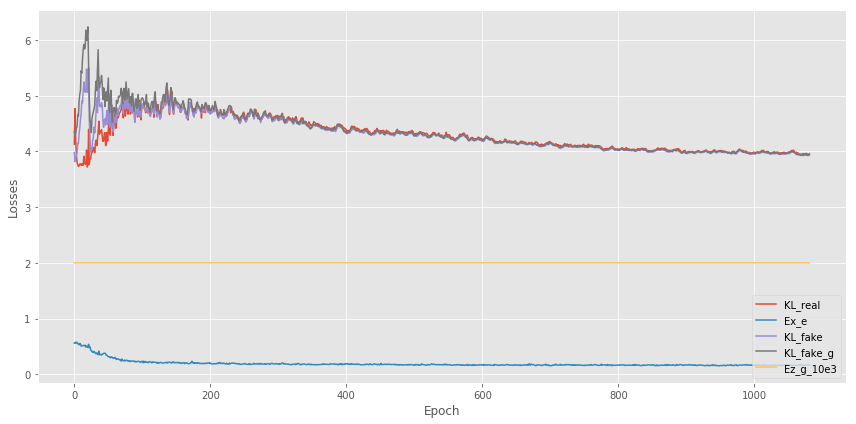

In [16]:
def show_train_hist(hist, show=False, save=False, path='Train_hist.png'):
    
    plt.figure(figsize = (12, 6))
    x = range(len(hist['KL_real']))
    for i, j in hist.items():
        if j: 
            plt.plot(x[:1082], j[:1082], label=i)
            
#     [plt.plot(x, j, label=i) for i, j in hist.items() if j]

    
    plt.xlabel('Epoch')
    plt.ylabel('Losses')
    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

#     if save: plt.savefig(path)
#     if show: plt.show()
#     else: plt.close()
    plt.show()

show_train_hist(losses)

In [17]:
len(losses['Ex_e'])

2175